## Import Package

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [8, 6]

## Load & Check Data

In [4]:
data = pd.DataFrame({
    
    'weeks':[36, 38, 39, 41, 37, 38, 40, 40, 38, 41, 38, 38, 40, 40, 36, 39, 40,
       35, 39, 38, 37, 43, 39, 39, 40, 40, 37, 38, 39, 38, 40, 40, 42, 37,
       41, 38, 37, 39, 40, 40, 38, 41, 38, 37, 39, 39, 43, 38, 38, 38],
    
    'weight':[2980, 2707, 3049, 3429, 2500, 2845, 3071, 3435, 3058, 3123, 3215,
       2902, 3015, 2983, 2727, 3121, 3114, 2511, 3327, 2864, 2749, 3621,
       2860, 3074, 3234, 3083, 2797, 3025, 3129, 2990, 3035, 2990, 3513,
       2687, 3380, 2863, 2715, 3012, 3083, 2938, 2837, 3455, 3175, 2646,
       2889, 2975, 3474, 3052, 3167, 2762],
    
    'gender':[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1]
})

In [5]:
data.head(10)

,weeks,weight,gender
0,36,2980,0
1,38,2707,1
2,39,3049,1
3,41,3429,1
4,37,2500,1
5,38,2845,1
6,40,3071,0
7,40,3435,0
8,38,3058,0
9,41,3123,1


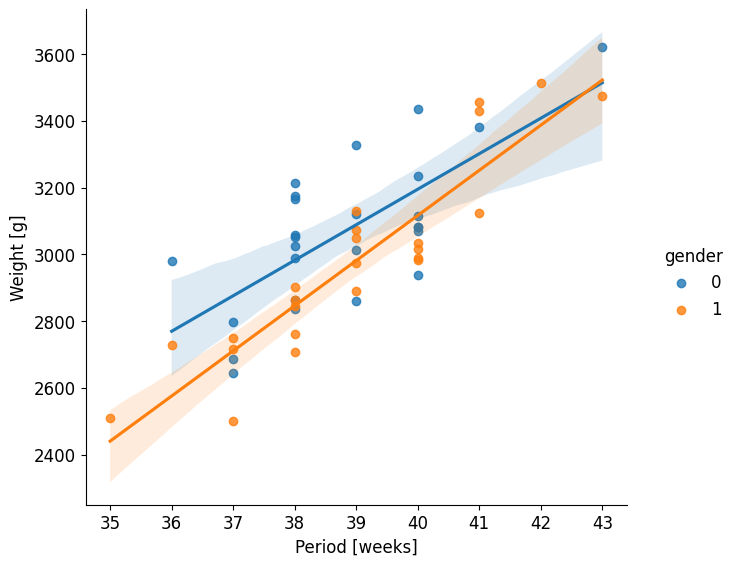

In [6]:
g = sns.lmplot(data=data, x='weeks', y='weight', hue='gender')

g.fig.set_figwidth(8)
g.fig.set_figheight(6)

plt.xlabel('Period [weeks]')
plt.ylabel('Weight [g]');

## Preprocess & Scale Data

In [7]:
x = data['weeks'].values
y = data['weight'].values

gender = data['gender'].values

In [8]:

x_mu = np.mean(x)
x_sd = np.std(x)

x_scaled = (x - x_mu) / x_sd

y_mu = np.mean(y)
y_sd = np.std(y)

y_scaled = (y - y_mu) / y_sd

## Define Model & Inference

In [9]:
def model(x_scaled=None, y_scaled=None, gender=None, num_data=0):
    
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(2,))
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(2,))
    
    mu = a[gender] * x_scaled + b[gender]
    
    sd = numpyro.sample('sd', dist.HalfCauchy(5))
    
    with numpyro.plate('plate_obs', num_data):
        
        numpyro.sample('obs', dist.Normal(mu, sd), obs=y_scaled)
        
    a_diff = numpyro.deterministic('a_diff', a[1] - a[0])
    b_diff = numpyro.deterministic('b_diff', b[1] - b[0])

In [10]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), x_scaled=x_scaled, y_scaled=y_scaled, gender=gender, num_data=len(y_scaled))

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [11]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

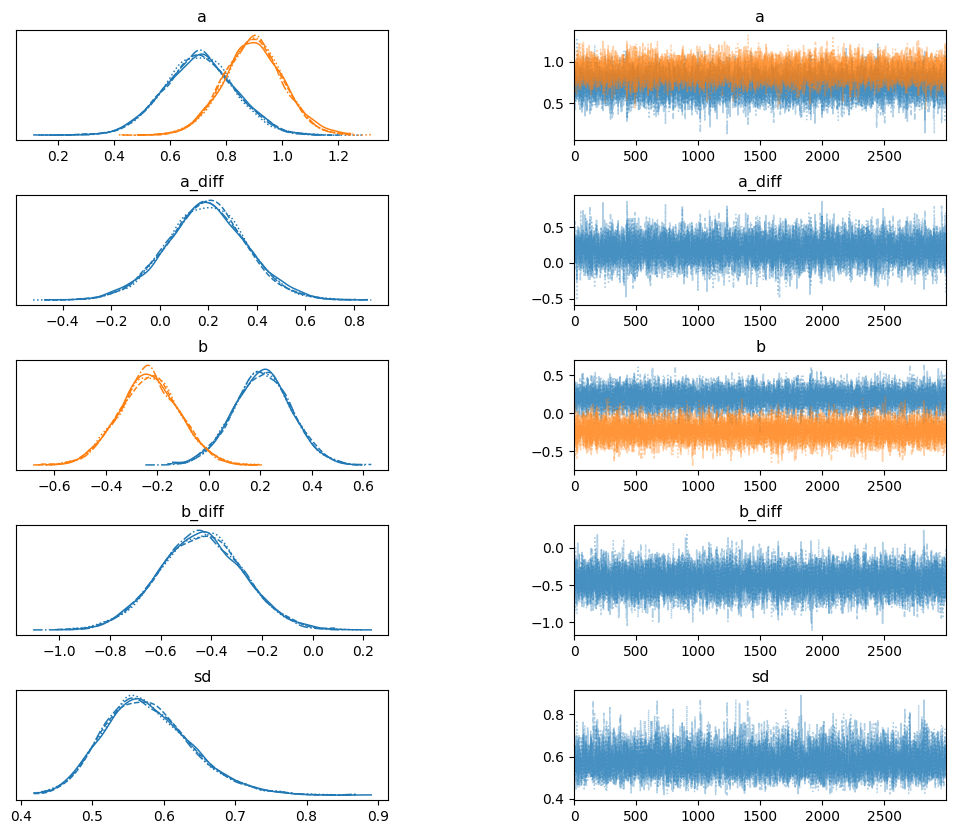

In [12]:
az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.704,0.128,0.458,0.937,0.001,0.001,15156.0,9139.0,1.0
a[1],0.896,0.107,0.698,1.100,0.001,0.001,14461.0,7852.0,1.0
a_diff,0.192,0.167,-0.104,0.529,0.001,0.002,14897.0,8054.0,1.0
b[0],0.208,0.113,-0.004,0.423,0.001,0.001,15694.0,9228.0,1.0
b[1],-0.233,0.118,-0.447,-0.002,0.001,0.001,16467.0,9228.0,1.0
b_diff,-0.440,0.165,-0.759,-0.138,0.001,0.002,15808.0,9452.0,1.0
sd,0.578,0.062,0.467,0.697,0.001,0.001,11389.0,8240.0,1.0


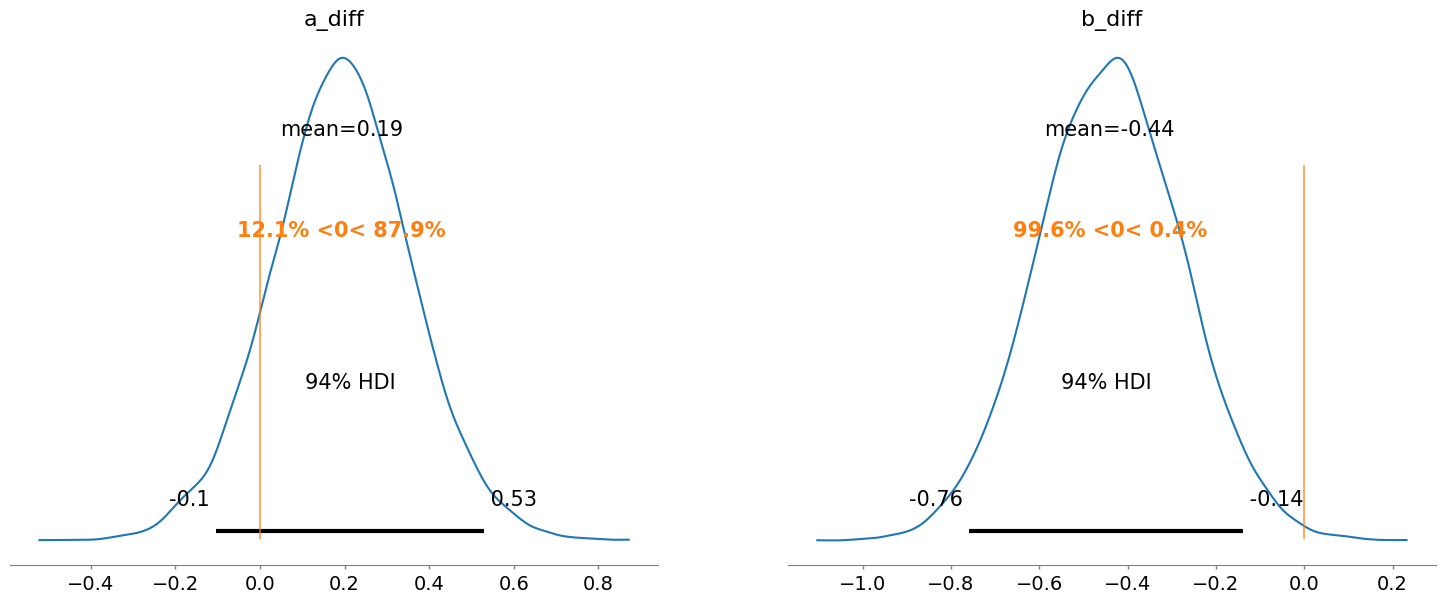

In [14]:
az.plot_posterior(idata, var_names=['a_diff', 'b_diff'], ref_val=0);

## Export Inference Data

In [15]:
az.to_netcdf(idata, 'idata.nc')

'idata.nc'